# **Pig_Chimerism**

**By Xiao Ma**

**Oct 9, 2023**

In [1]:
start_time <- Sys.time()

This R notebook analysed the [bulk RNA-Seq data](https://s3.msi.umn.edu/djglab/Garry_Project_112and114_pig_bulkRNA_31samples_genename.rds) from [Pig_Chimerism](https://github.com/djglab/Pig_Chimerism).
Resolve [Issue 6](https://github.com/djglab/Pig_Chimerism/issues/6).

In [2]:
library(cluster)
library(ggplot2)
library(ComplexHeatmap)
library(dplyr)
library(DESeq2)
library(biomaRt)
library(tidyverse)
library(circlize)
library(AnnotationDbi)
library(org.Ss.eg.db)
library(clusterProfiler)
library(RColorBrewer)
library(pheatmap)
library(vsn)
library(factoextra)
library(scales)
library(ReactomePA)
library(ggrepel)
library(jsonlite)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

# Global Setting

In [3]:
mycol <- readRDS(url("https://s3.msi.umn.edu/ma000332/mycol.rds"))

**p value cutoff for DEseq analysis**

In [4]:
p_cutoff <- 0.05

**q value cutoff for DEseq analysis**

In [5]:
q_cutoff <- 0.05

In [6]:
fc_cutoff <- 1

# Download data processed on MSI

In [7]:
tx2gene <- read.csv("tx2gene.csv")

The [R code](https://github.com/djglab/Pig_Chimerism/blob/main/txi_fullmport.R) for generated this rds file is available.

In [8]:
txi_full_file <- "https://s3.msi.umn.edu/djglab/Garry_Project_112_114_117_pig_bulkRNA_33samples_genename.rds"
txi_full <- txi_full_file %>%  url() %>%  gzcon() %>%  readRDS()

# Exclude the first two WT samples which are not of good quality

In [9]:
remain_sample <- setdiff(colnames(txi_full$abundance), c('WT_176-8477-2_RHL_S8_L001','WT_181-0991-3_RHL_S7_L001'))

In [10]:
length(remain_sample)

[1] 31

In [11]:
txi_full <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [12]:
txi_full$countsFromAbundance <- "no"

# Coldata

In [13]:
coldata <- data.frame(sample = colnames(txi_full$counts)) %>%
  mutate(condition = c(rep("SKM_Null",11), rep("C3_Null",3), rep("WT",4), rep("NE_Null",3), rep("Nkx2_5_KO",2), rep("WT",2), rep("SKM_Null",2), rep("WT",4)),
         time = c(rep("E62",2), rep("E29",3), rep("E34",6), rep("E18",3), rep("E90",4), rep("E18",7), rep("E41",2), rep("E62",2), rep("E41",2)))

In [14]:
coldata

sample,condition,time
<chr>,<chr>,<chr>
212-4281_E62SKM_RHL_Emb1_S1,SKM_Null,E62
212-4281_E62SKM_RHL_Emb4_S2,SKM_Null,E62
216-3340_Emb1_HL_S3,SKM_Null,E29
216-3340_Emb2_HL_S4,SKM_Null,E29
216-3340_Emb5_HL_S5,SKM_Null,E29
217-6710_Emb2_BW_S6,SKM_Null,E34
217-6710_Emb2_HL_S7,SKM_Null,E34
217-6710_Emb3_BW_S8,SKM_Null,E34
217-6710_Emb3_HL_S9,SKM_Null,E34


**Columns of the count matrix and the rows of the column data must be in the same order** <br> DESeq2 will not make guesses as to which column of the count matrix belongs to which row of the column data, these must be provided to DESeq2 already in consistent order.

In [15]:
all(coldata$sample == colnames(txi_full$counts))

[1] TRUE

# Data quality access: PCA Plot

**Variance Stabilizing Transformation**

In [16]:
Pca_plot <- function(dds_res, color_fac){
    
set.seed(5)
vsd <- vst(dds_res, blind=FALSE) 
    
rv <- rowVars(assay(vsd)) #Get the order of the row varances in each row
select <- order(rv, decreasing = T)[seq_len(min(500, length(rv)))]
pca <- prcomp(t(assay(vsd)[select, ])) #Select 500 genes with largest variances

pcaData <- cbind(as.data.frame(pca$x), colData(dds_res))

percentVar <- round(pca$sdev^2/sum(pca$sdev^2)*10000)/100
    
p <- ggplot(pcaData, aes(PC1, PC2, color = pcaData[[color_fac]], label = sample)) +
  geom_point(size=5) + 
    geom_label_repel(nudge_x = 0, nudge_y = 0) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + 
  theme_bw() + 
  theme(legend.title= element_text(),
        axis.title.x = element_text(size = 14),
        axis.text.x  = element_text(size = 12),
        axis.title.y = element_text(size = 14)) + 
    scale_color_manual(values = mycol)
return(p)
}

# Comparison between WT samples

In [17]:
coldata_WT <- coldata %>%
filter(time %in% c("E41", "E62", "E90") & condition == "WT") %>%
mutate(time = as.factor(time))

In [18]:
coldata_WT

sample,condition,time
<chr>,<chr>,<fct>
6132-1_Right_Gastroc_S15,WT,E90
6132-2_Left_Sol_S16,WT,E90
6132-3_Left_Sol_S17,WT,E90
6132-3_Right_Gastroc_S18,WT,E90
WT62_0987-3_RHL_S9_L001,WT,E62
WT62_0987-4_RHL_S10_L001,WT,E62
181-0991-1_LHL_S1_L001,WT,E41
181-0991-3_LHL_S2_L001,WT,E41


In [19]:
remain_sample <- coldata_WT %>% pull(sample)

In [20]:
txi_WT <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [21]:
txi_WT$countsFromAbundance <- txi_full$countsFromAbundance

In [22]:
all(coldata_WT$sample == colnames(txi_WT$counts))

[1] TRUE

In [23]:
dds_WT <- DESeqDataSetFromTximport(txi_WT, coldata_WT,  design = ~ time)

using counts and average transcript lengths from tximport



In [24]:
summary(rowSums(counts(dds_WT)) >= 10)

   Mode   FALSE    TRUE 
logical    1024   14659 

In [25]:
dds_WT <- dds_WT[rowSums(counts(dds_WT)) >= 10,]

In [26]:
dds_res_WT <- DESeq(dds_WT)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


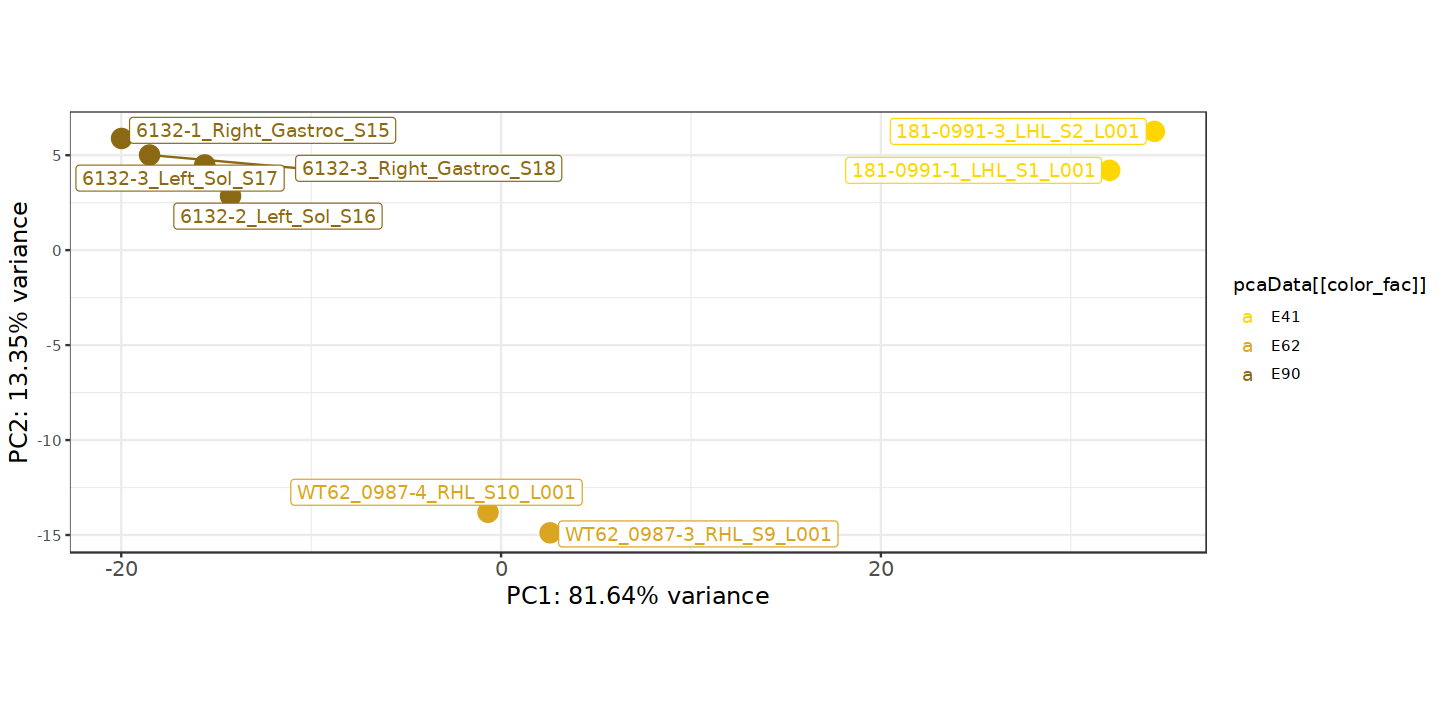

In [27]:
options(repr.plot.width=12, repr.plot.height = 6)
Pca_plot(dds_res_WT, "time")

In [28]:
png("Figure_SKM/PCA_WT.png",width=10,height=4,units="in",res=1200)
Pca_plot(dds_res_WT, "time")
dev.off() 

Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


png 
  2

# Compare WT samples and Null models at respective time points

## E41

In [29]:
coldata_E41 <- coldata %>% filter(time == "E41")

In [30]:
coldata_E41

sample,condition,time
<chr>,<chr>,<chr>
SKM_0923-1_RHL_S5_L001,SKM_Null,E41
SKM_0923-3_RHL_S6_L001,SKM_Null,E41
181-0991-1_LHL_S1_L001,WT,E41
181-0991-3_LHL_S2_L001,WT,E41


In [31]:
remain_sample <- coldata_E41 %>% pull(sample)

In [32]:
txi_E41 <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [33]:
txi_E41$countsFromAbundance <- txi_full$countsFromAbundance

In [34]:
all(coldata_E41$sample == colnames(txi_E41$counts))

[1] TRUE

In [35]:
dds_E41 <- DESeqDataSetFromTximport(txi_E41, coldata_E41, design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [36]:
summary(rowSums(counts(dds_E41)) >= 10)

   Mode   FALSE    TRUE 
logical    1396   14287 

In [37]:
dds_E41 <- dds_E41[rowSums(counts(dds_E41)) >= 10,]

In [38]:
dds_res_E41 <- DESeq(dds_E41)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


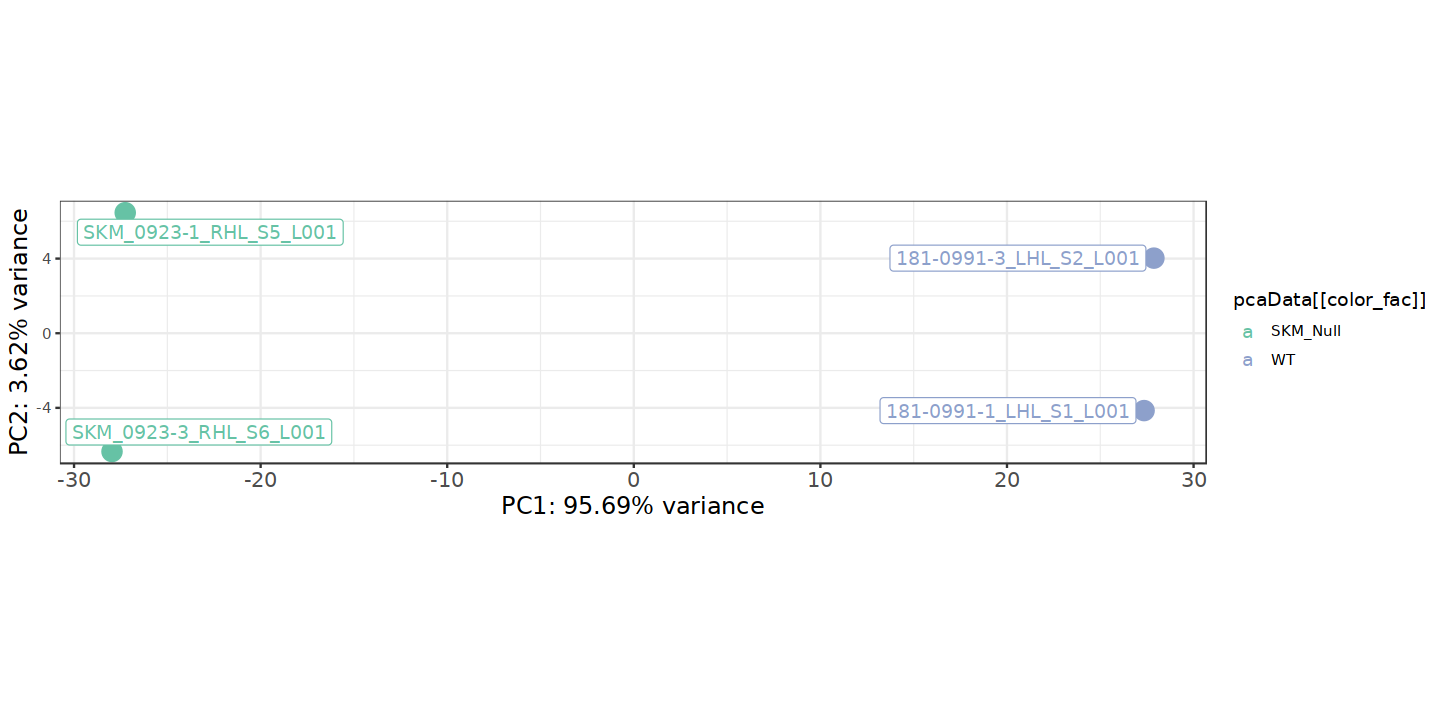

In [39]:
options(repr.plot.width=12, repr.plot.height = 6)
Pca_plot(dds_res_E41, "condition")

In [40]:
png("Figure_SKM/PCA_E41.png",width=8,height=4,units="in",res=1200)
Pca_plot(dds_res_E41, "condition")
dev.off() 

Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


png 
  2

## E62

In [41]:
coldata_E62 <- coldata %>% filter(time == "E62")

In [42]:
coldata_E62

sample,condition,time
<chr>,<chr>,<chr>
212-4281_E62SKM_RHL_Emb1_S1,SKM_Null,E62
212-4281_E62SKM_RHL_Emb4_S2,SKM_Null,E62
WT62_0987-3_RHL_S9_L001,WT,E62
WT62_0987-4_RHL_S10_L001,WT,E62


In [43]:
remain_sample <- coldata_E62 %>% pull(sample)

In [44]:
txi_E62 <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [45]:
txi_E62$countsFromAbundance <- txi_full$countsFromAbundance

In [46]:
all(coldata_E62$sample == colnames(txi_E62$counts))

[1] TRUE

In [47]:
dds_E62 <- DESeqDataSetFromTximport(txi_E62, coldata_E62, design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [48]:
dds_E62 <- dds_E62[rowSums(counts(dds_E62)) >= 10,]

In [49]:
dds_res_E62 <- DESeq(dds_E62)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


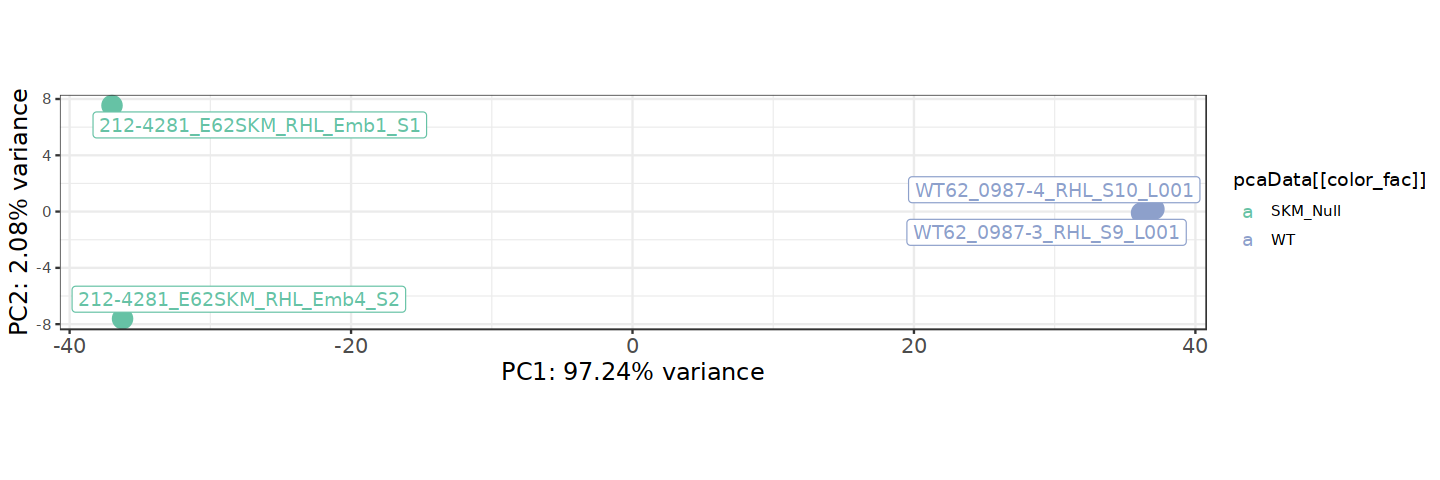

In [50]:
options(repr.plot.width=12, repr.plot.height = 4)
Pca_plot(dds_res_E62, "condition")

# Comparison between SKM_Null samples

In [51]:
coldata_SKM_Null <- coldata %>%
filter(time %in% c("E41", "E62", "E90") & condition == "SKM_Null")

In [52]:
coldata_SKM_Null

sample,condition,time
<chr>,<chr>,<chr>
212-4281_E62SKM_RHL_Emb1_S1,SKM_Null,E62
212-4281_E62SKM_RHL_Emb4_S2,SKM_Null,E62
SKM_0923-1_RHL_S5_L001,SKM_Null,E41
SKM_0923-3_RHL_S6_L001,SKM_Null,E41


In [53]:
remain_sample <- coldata_SKM_Null %>% pull(sample)

In [54]:
txi_SKM_Null <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [55]:
txi_SKM_Null$countsFromAbundance <- txi_full$countsFromAbundance

In [56]:
all(coldata_SKM_Null$sample == colnames(txi_SKM_Null$counts))

[1] TRUE

In [57]:
dds_SKM_Null <- DESeqDataSetFromTximport(txi_SKM_Null, coldata_SKM_Null,  design = ~ time)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [58]:
summary(rowSums(counts(dds_SKM_Null)) >= 10)

   Mode   FALSE    TRUE 
logical    1136   14547 

In [59]:
dds_SKM_Null <- dds_SKM_Null[rowSums(counts(dds_SKM_Null)) >= 10,]

In [60]:
dds_res_SKM_Null <- DESeq(dds_SKM_Null)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”


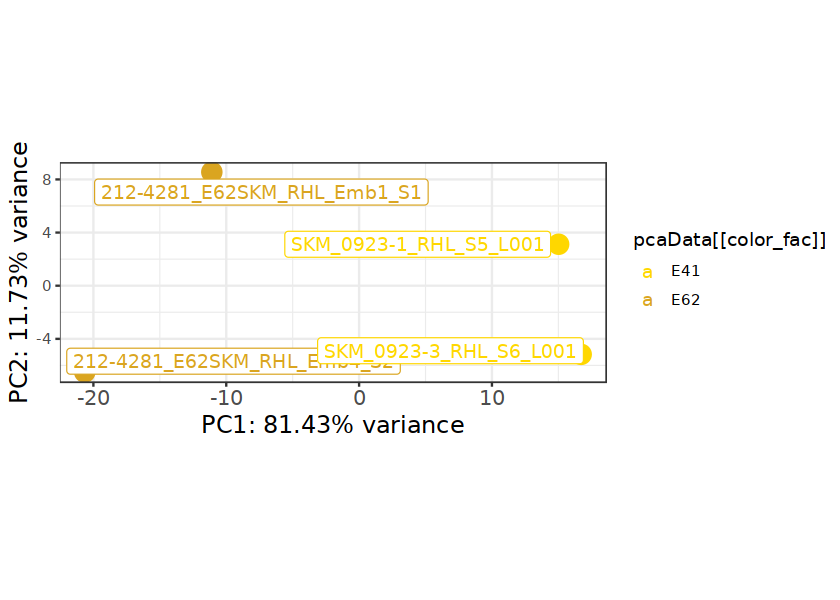

In [61]:
options(repr.plot.width=7, repr.plot.height = 5)
Pca_plot(dds_res_SKM_Null, "time")

# Comparison between E90 tissue

In [62]:
coldata_E90 <- coldata %>%
filter(time %in% c("E90"))%>%
mutate(tissue = c("Gastroc","Soleus","Soleus", "Gastroc"))

In [63]:
coldata_E90

sample,condition,time,tissue
<chr>,<chr>,<chr>,<chr>
6132-1_Right_Gastroc_S15,WT,E90,Gastroc
6132-2_Left_Sol_S16,WT,E90,Soleus
6132-3_Left_Sol_S17,WT,E90,Soleus
6132-3_Right_Gastroc_S18,WT,E90,Gastroc


In [64]:
remain_sample <- coldata_E90 %>% pull(sample)

In [65]:
txi_E90 <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [66]:
txi_E90$countsFromAbundance <- txi_full$countsFromAbundance

In [67]:
all(txi_E90$sample == colnames(txi_E90$counts))

[1] TRUE

In [68]:
dds_E90 <- DESeqDataSetFromTximport(txi_E90, coldata_E90,  design = ~ tissue)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [69]:
summary(rowSums(counts(dds_E90)) >= 10)

   Mode   FALSE    TRUE 
logical    1291   14392 

In [70]:
dds_E90 <- dds_E90[rowSums(counts(dds_E90)) >= 10,]

In [71]:
dds_res_E90 <- DESeq(dds_E90)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“Use of `pcaData[[color_fac]]` is discouraged.
ℹ Use `.data[[color_fac]]` instead.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


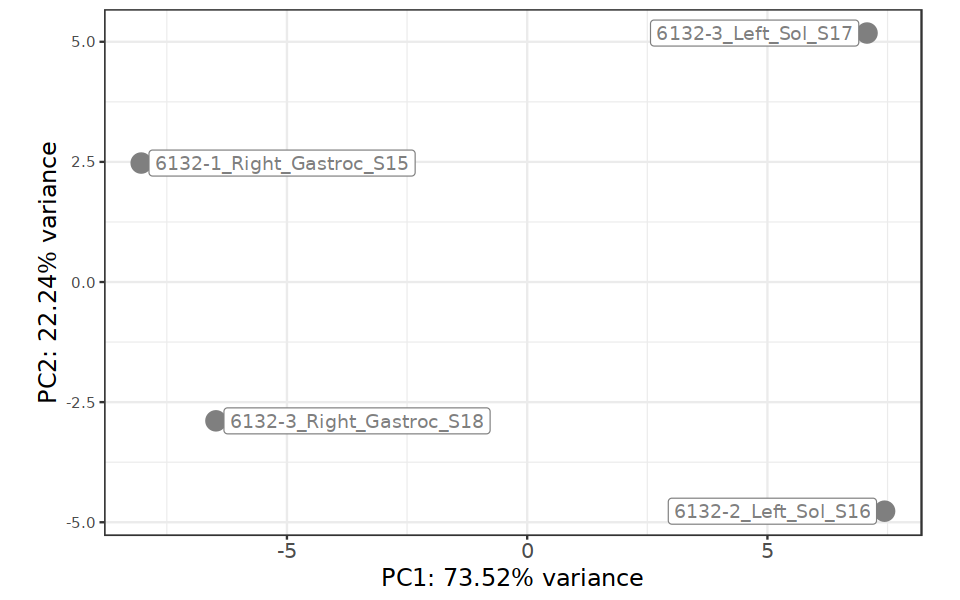

In [72]:
options(repr.plot.width=8, repr.plot.height = 5)
Pca_plot(dds_res_E90, "tissue")

# Comparasion

In [73]:
res1 <- results(dds_res_WT, alpha = p_cutoff, contrast = c("time", "E62", "E41")) ### 1. E62 WT vs E41 WT

In [74]:
res2 <- results(dds_res_WT, alpha = p_cutoff, contrast = c("time", "E90", "E62")) ### 2. E90 WT vs E62 WT

In [75]:
res3 <- results(dds_res_E41, alpha = p_cutoff, contrast = c("condition", "SKM_Null", "WT")) ### 3. E41 SKM_Null vs E41 WT

In [76]:
res4 <- results(dds_res_E62, alpha = p_cutoff, contrast = c("condition", "SKM_Null", "WT")) ### 4. E62 SKM_Null vs E62 WT

In [77]:
res5 <- results(dds_res_SKM_Null, alpha = p_cutoff, contrast = c("time", "E62", "E41")) ### 5. E62 SKM_Null vs E41 SKM_Null

In [78]:
res6 <- results(dds_res_E90, alpha = p_cutoff, contrast = c("tissue", "Gastroc", "Soleus")) ### 6. E90 WT Gastroc vs E90 WT Soleus

In [79]:
res7 <- results(dds_res_WT, alpha = p_cutoff, contrast = c("time", "E90", "E41")) ### 7. E90 WT vs E41 WT

## Differential expressed gene for each comparasion

In [80]:
data <- lapply(list(res1, res2, res3, res4, res5, res6, res7), function(x){
       as.data.frame(x) %>%
       mutate(gene_name = rownames(x)) %>%
       filter(!is.na(padj)) %>%
       mutate(Expression = case_when(log2FoldChange > fc_cutoff & padj < p_cutoff ~ "Up",
                                     log2FoldChange < -fc_cutoff & padj < p_cutoff ~ "Down",
                                     TRUE ~ "Not Sig")) %>%
      mutate(Expression = factor(Expression, levels = c("Up", "Not Sig", "Down")))
})

In [81]:
openxlsx::write.xlsx(lapply(data, function(i){
   i %>%
dplyr::select(gene_name, log2FoldChange, padj, Expression)
}), "Figure_SKM/SKM.xlsx", rowNames = F, zoom = 200)

In [82]:
a <- list(data[[3]],data[[4]])

In [83]:
names(a) <- c("E41", "E62")

In [84]:
openxlsx::write.xlsx(lapply(a, function(i){
   i %>%
dplyr::select(gene_name, log2FoldChange, padj, Expression) %>%
filter(Expression != "Not Sig") %>%
mutate(log2FoldChange = round(log2FoldChange, digit = 2)) %>%
arrange(-log2FoldChange, padj)
    
}), "Figure_SKM/DEG_E41_E62.xlsx", rowNames = F, zoom = 200)

# Volcano plot

In [85]:
Volcano_plot <- function(data, top, mark = "", filter_fc = Inf){
    data <- data %>% filter(log2FoldChange < filter_fc)

    top_genes <- bind_rows(
    data %>% 
    filter(Expression == 'Up' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),

    data %>% 
    filter(Expression == 'Down' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top))
set.seed(5)
p <- ggplot(data = data, aes(log2FoldChange, -log(padj, 10))) + 
    geom_point(aes(color = Expression), size = 0.2) +
    scale_color_manual(values = c("firebrick3", "gray55", "dodgerblue3")) +
    guides(colour = guide_legend(override.aes = list(size=3))) +
    geom_label_repel(data = top_genes,
                   mapping = aes(log2FoldChange, -log(padj,10), label = gene_name, color = Expression), label.padding = unit(0.7,"mm"),
                   size = 3, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, label.size = NA, family = "sans") +
    geom_label_repel(data = data[mark,],
                     mapping = aes(log2FoldChange, -log(padj,10), label = gene_name, color = Expression), 
                     label.padding = unit(1,"mm"),
                     size = 4, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, fontface= 'bold', family =  "sans") + 
         theme_classic(base_size = 10) +
  theme(text=element_text(size=16,  family="sans"))+
  #  theme(axis.text = element_text(), axis.title = element_text(), legend.position="none")
  guides(color = guide_legend(override.aes = aes(label = "")))
    
return(p)
}

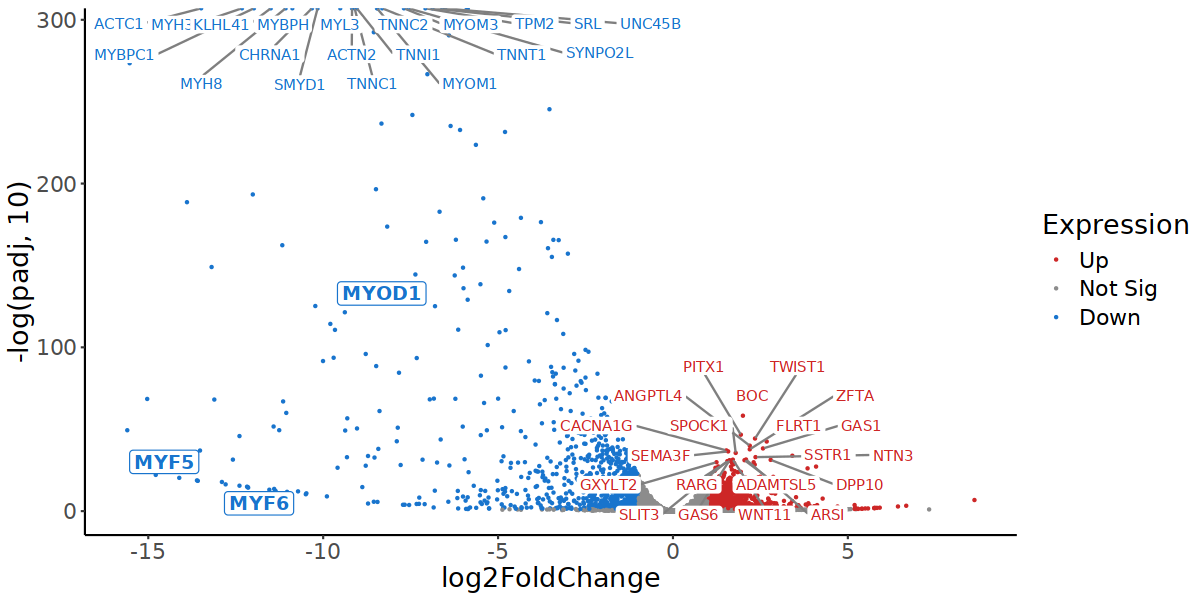

In [86]:
options(repr.plot.width=10, repr.plot.height = 5)
Volcano_plot(data[[3]], 20, mark = c("MYF5","MYF6","MYOD"))

## Up pathways

In [87]:
Up_pathway <- function(data){
               enrichGO(gene = data %>% 
                               filter(Expression == 'Up') %>%
                               pull(gene_name),
               OrgDb         = org.Ss.eg.db,
               ont           = "BP",
               pAdjustMethod = "BH",
               keyType       = "SYMBOL",
               pvalueCutoff  = p_cutoff,
               qvalueCutoff  = q_cutoff,
               readable = TRUE)    
}

In [88]:
Up_pathway <- lapply(data, Up_pathway)

## Down pathways

In [89]:
Down_pathway <- function(data){
               enrichGO(gene = data %>% 
                               filter(Expression == 'Down') %>%
                               pull(gene_name),
               OrgDb         = org.Ss.eg.db,
               ont           = "BP",
               pAdjustMethod = "BH",
               keyType       = "SYMBOL",
               pvalueCutoff  = p_cutoff,
               qvalueCutoff  = q_cutoff,
               readable = TRUE)    
}

In [90]:
Down_pathway <- lapply(data, Down_pathway)

# Results

## 3. E41 SKM_Null vs E41 WT

In [91]:
table(data[[3]]$Expression)


     Up Not Sig    Down 
   1085   11825    1100 

In [92]:
Volcano_plot_noname <- function(data, top, mark = "", filter_fc = Inf){
    data <- data %>% filter(log2FoldChange < filter_fc)

    top_genes <- bind_rows(
    data %>% 
    filter(Expression == 'Up' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),

    data %>% 
    filter(Expression == 'Down' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top))
set.seed(5)
p <-  ggplot(data = data, aes(log2FoldChange, -log(padj, 10))) + 
    geom_point(aes(color = Expression), size = 0.1) +
    scale_color_manual(values = c("firebrick3", "gray55", "dodgerblue3")) +
    guides(colour = guide_legend(override.aes = list(size=3))) +
    geom_label_repel(data = top_genes,
                   mapping = aes(log2FoldChange, -log(padj,10), label = gene_name), color = "white", label.padding = unit(0.7,"mm"),
                   size = 3, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, label.size = NA, family = "sans") +
    geom_label_repel(data = data[mark,],
                     mapping = aes(log2FoldChange, -log(padj,10), label = gene_name), color = "white", label.padding = unit(1,"mm"),
                     size = 4, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, fontface= 'bold', family =  "sans") + 
         theme_classic(base_size = 10) +
  theme(axis.text = element_text(), axis.title = element_text(), legend.position="none")
  guides(color = guide_legend(override.aes = aes(label = "")))
    
return(p)
}

In [93]:
Volcano_plot_blackname <- function(data, top, mark = "", filter_fc = Inf){
    data <- data %>% filter(log2FoldChange < filter_fc)

    top_genes <- bind_rows(
    data %>% 
    filter(Expression == 'Up' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),

    data %>% 
    filter(Expression == 'Down' & gene_name != "") %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top))
set.seed(5)
p <-  ggplot(data = data, aes(log2FoldChange, -log(padj, 10))) + 
    geom_point(aes(color = Expression), size = 0.1) +
    scale_color_manual(values = c("firebrick3", "gray55", "dodgerblue3")) +
    guides(colour = guide_legend(override.aes = list(size=3))) +
    geom_label_repel(data = top_genes,
                   mapping = aes(log2FoldChange, -log(padj,10), label = gene_name, color = Expression), label.padding = unit(0.7,"mm"),
                   size = 3, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, label.size = NA, family = "sans") +
    geom_label_repel(data = data[mark,],
                     mapping = aes(log2FoldChange, -log(padj,10), label = gene_name, color = Expression), label.padding = unit(1,"mm"),
                     size = 4, max.overlaps = Inf, segment.color = 'grey50',  show.legend = F, fontface= 'bold', family =  "sans") + 
         theme_classic(base_size = 10) +
  theme(axis.text = element_text(), axis.title = element_text(), legend.position="none")
  guides(color = guide_legend(override.aes = aes(label = "")))
    
return(p)
}

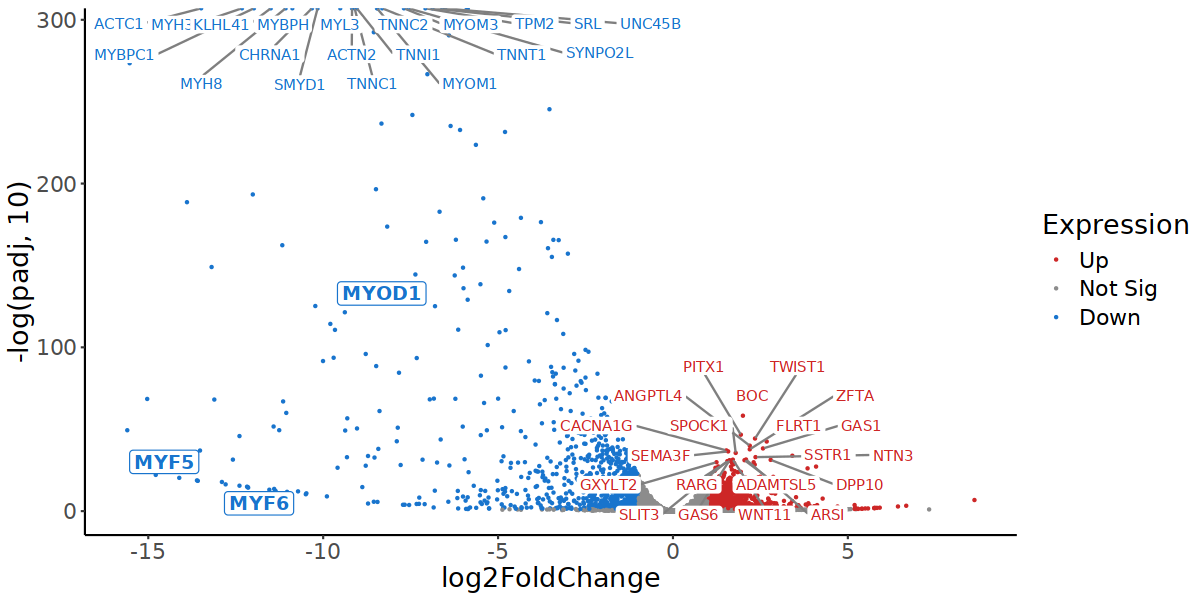

In [94]:
options(repr.plot.width = 10, repr.plot.height = 5)
Volcano_plot(data[[3]], 20, mark = c("MYF5","MYF6","MYOD"))

In [95]:
png("Figure_SKM/VolcanoE41_axisblank.png",width=6,height=4,units="in",res=1200)
Volcano_plot_blackname(data[[3]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

In [96]:
png("Figure_SKM/VolcanoE41.png",width=7,height=4,units="in",res=1200)
Volcano_plot(data[[3]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

In [97]:
png("Figure_SKM/VolcanoE41_blank.png",width=6,height=4,units="in",res=1200)
Volcano_plot_noname(data[[3]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


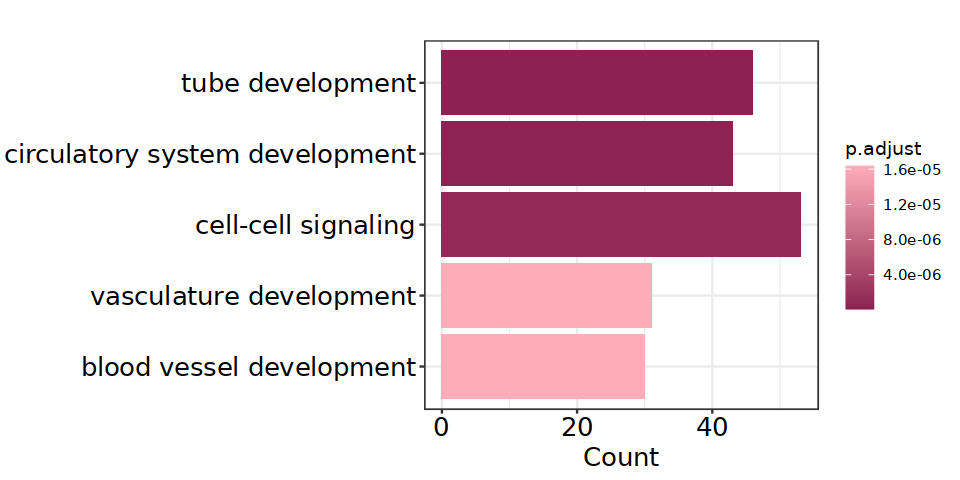

In [98]:
options(repr.plot.width = 8, repr.plot.height = 4)
barplot(Up_pathway[[3]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 15, label_format = 60, fontfamily = "sans", fontface = "bold") +
        scale_fill_gradient(low = "violetred4", high = "lightpink1") 

In [99]:
png("Figure_SKM/GOUp3.png",width=1.1,height=2.1,units="in",res=1200)
barplot(Up_pathway[[3]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 0, label_format = 60, fontfamily = "sans", fontface = "bold") +
        scale_fill_gradient(low = "violetred4", high = "lightpink1") +
        theme(legend.position = "none")
dev.off() 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


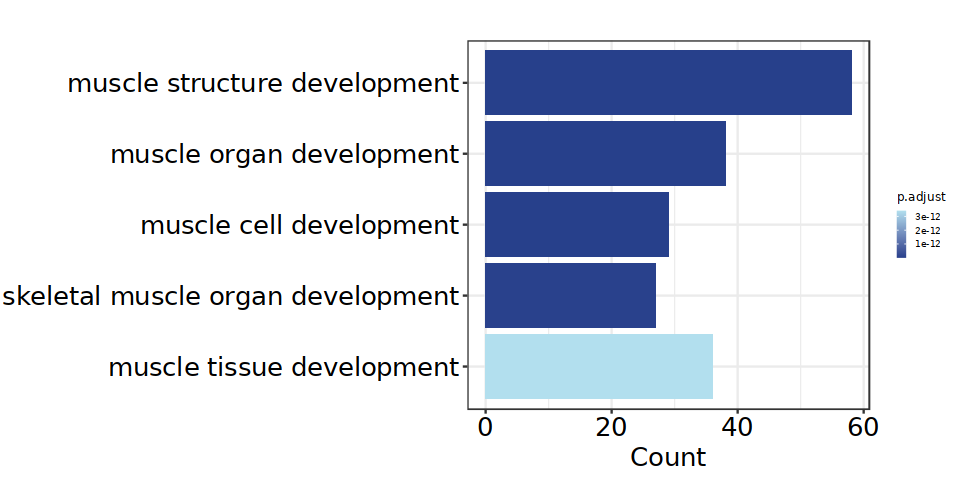

In [100]:
barplot(Down_pathway[[3]] %>%
  filter(str_detect(Description,"pathway|signaling|development")) %>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 15, label_format = 40) +
        scale_fill_gradient(low = "royalblue4", high = "lightblue2") +
        theme(legend.key.size = unit(2, 'mm'),
             legend.text=element_text(size=5),
             legend.title=element_text(size=7))

In [101]:
png("Figure_SKM/GODown3.png",width=1.1,height=2.1,units="in",res=1200)
barplot(Down_pathway[[3]] %>%
  filter(str_detect(Description,"pathway|signaling|development")) %>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 0, label_format = 40) +
        scale_fill_gradient(low = "royalblue4", high = "lightblue2") +
        theme(legend.position = "none")
dev.off() 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

## Mark gene related with "tube development", "vasculature development" and "blood vessel development"

In [102]:
MG <- c("ACTG1", "MYF5", "MYOD1", "TNNI1", "TNNI2", "MYF6", "MYOG", "MYH3", "DMD", "MYH7B", "MYH15", "PAX7", "MYH13", "MYOT", "DES", "MYLK2", "TWIST2", "ACKR3", "WNT11", "TWIST1", "ANGPTL4", "SHC1", "EPHB3", "CCBE1", "GLI2", "RSPO3")

In [103]:
scale <- scale(t(counts(dds_res_E41, normalized=T)[rownames(dds_res_E41) %in% MG,]))
res_scaled <- t(scale)

In [104]:
coldata_E41

sample,condition,time
<chr>,<chr>,<chr>
SKM_0923-1_RHL_S5_L001,SKM_Null,E41
SKM_0923-3_RHL_S6_L001,SKM_Null,E41
181-0991-1_LHL_S1_L001,WT,E41
181-0991-3_LHL_S2_L001,WT,E41


In [105]:
condition_level <- c("WT", "SKM_Null")

column_annotation <- HeatmapAnnotation(
 condition = c("WT","WT", "SKM_Null","SKM_Null"), 
 simple_anno_size = unit(3, "mm"),
 col =list(condition = mycol[c("WT", "SKM_Null")]),
  gp = gpar(col = "white") ,  
  annotation_name_gp = gpar(fontsize = 0), 
  show_legend = F,
  annotation_legend_param = list(at = c(condition_level), title_gp = gpar(fontsize = 0),labels_gp = gpar(fontsize = 0))
)

col_fun <- colorRamp2(quantile(res_scaled, c(0.05, 0.5, 0.95)), c("blue", "black", "red"))

In [106]:
coldata_E41

sample,condition,time
<chr>,<chr>,<chr>
SKM_0923-1_RHL_S5_L001,SKM_Null,E41
SKM_0923-3_RHL_S6_L001,SKM_Null,E41
181-0991-1_LHL_S1_L001,WT,E41
181-0991-3_LHL_S2_L001,WT,E41


In [107]:
res_scaled <- res_scaled[MG, c("181-0991-1_LHL_S1_L001", "181-0991-3_LHL_S2_L001", "SKM_0923-1_RHL_S5_L001", "SKM_0923-3_RHL_S6_L001")]

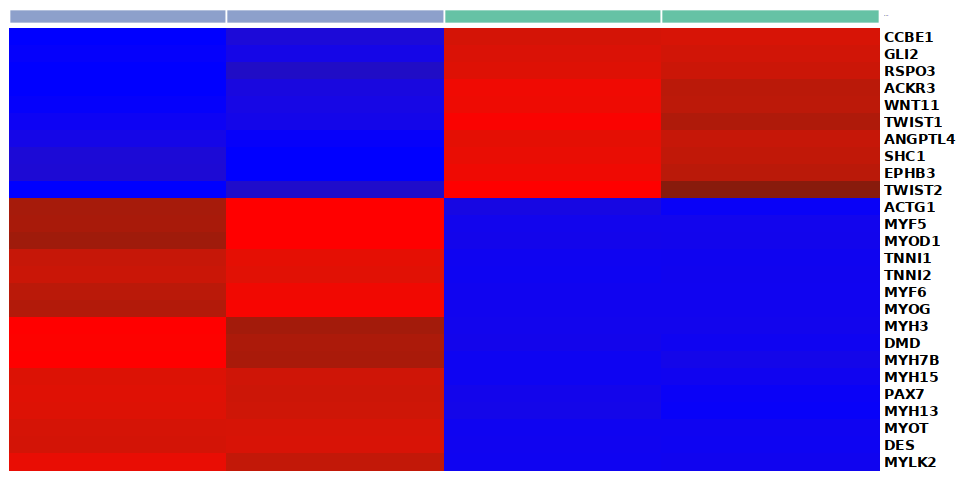

In [108]:
ht_opt$message = F
set.seed(12)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled, # Whether make cluster on columns or rows
cluster_rows = T, #Cluster the genes according to the pre-defined gene dendrogram
#row_km = 2,
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [109]:
png("Figure_SKM/MG_heatmap_E41.png",width=2.5,height=4.5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

## Another long heatmap, add 5 genes with pig heart

In [110]:
MG <- c("ACTG1", "MYF5", "MYOD1", "TNNI1", "TNNI2", "MYF6", "MYOG", "MYH3", "DMD", "MYH7B", "MYH15", "PAX7", "MYH13", "MYOT", "DES", "MYLK2", "MUSK","ETV4", "LRP4",
        "TWIST2", "ACKR3", "WNT11", "TWIST1", "ANGPTL4", "SHC1", "EPHB3", "CCBE1", "GLI2", "RSPO3","AGRN","SOX10")

In [111]:
scale <- scale(t(counts(dds_res_E41, normalized=T)[rownames(dds_res_E41) %in% MG,]))
res_scaled <- t(scale)

In [112]:
res_scaled <- res_scaled[MG, c("181-0991-1_LHL_S1_L001", "181-0991-3_LHL_S2_L001", "SKM_0923-1_RHL_S5_L001", "SKM_0923-3_RHL_S6_L001")]

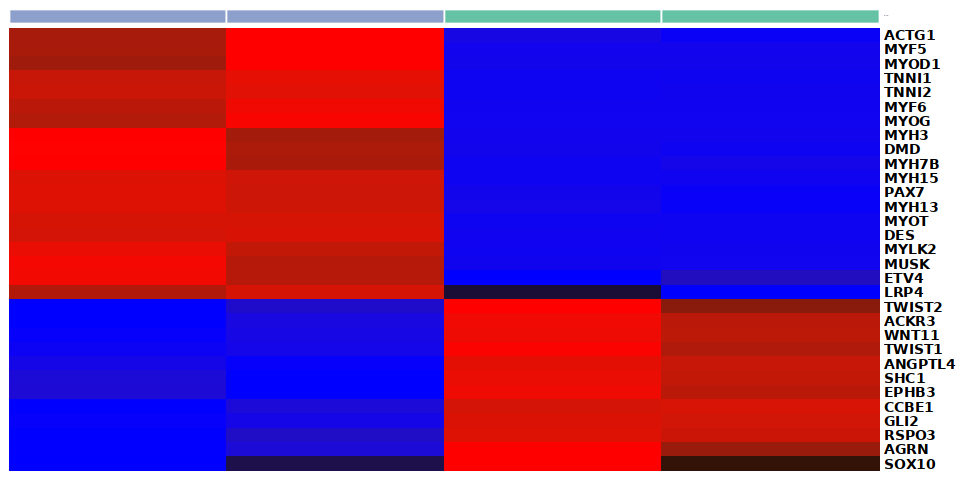

In [113]:
ht_opt$message = F
set.seed(12)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled, # Whether make cluster on columns or rows
cluster_rows = F, #Cluster the genes according to the pre-defined gene dendrogram
#row_km = 2,
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [114]:
png("Figure_SKM/MG_heatmap_E41_updated.png",width=2.5,height=5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

## Hematmap of another genelist provided by Mary

### E41

In [115]:
scale <- scale(t(counts(dds_res_E41, normalized=T)[rownames(dds_res_E41) %in% c("LRP4","ETV4","MUSK","SOX10","AGRN"),]))
res_scaled <- t(scale)

In [116]:
res_scaled <- res_scaled[c("LRP4","ETV4","MUSK","SOX10","AGRN"), c("181-0991-1_LHL_S1_L001", "181-0991-3_LHL_S2_L001", "SKM_0923-1_RHL_S5_L001", "SKM_0923-3_RHL_S6_L001")]

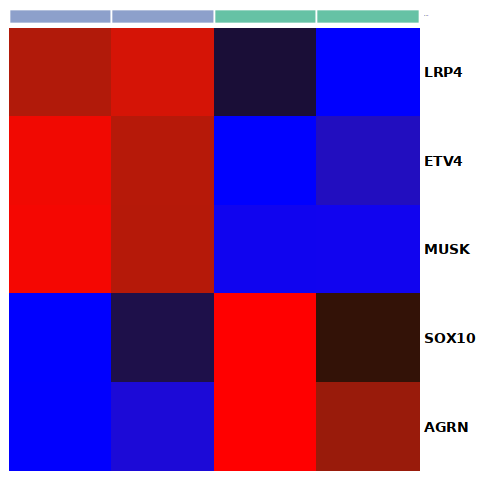

In [117]:
options(repr.plot.width=4, repr.plot.height = 4)
ht_opt$message = F
set.seed(5)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled,
cluster_rows = F, #Cluster the genes according to the pre-defined gene dendrogram
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [118]:
png("Figure_SKM/MG_heatmap_E41_v2.png",width=2.5,height=1.5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

## 4. E62 SKM_Null vs E62 WT

In [119]:
table(data[[4]]$Expression)


     Up Not Sig    Down 
   1760   11126    1599 

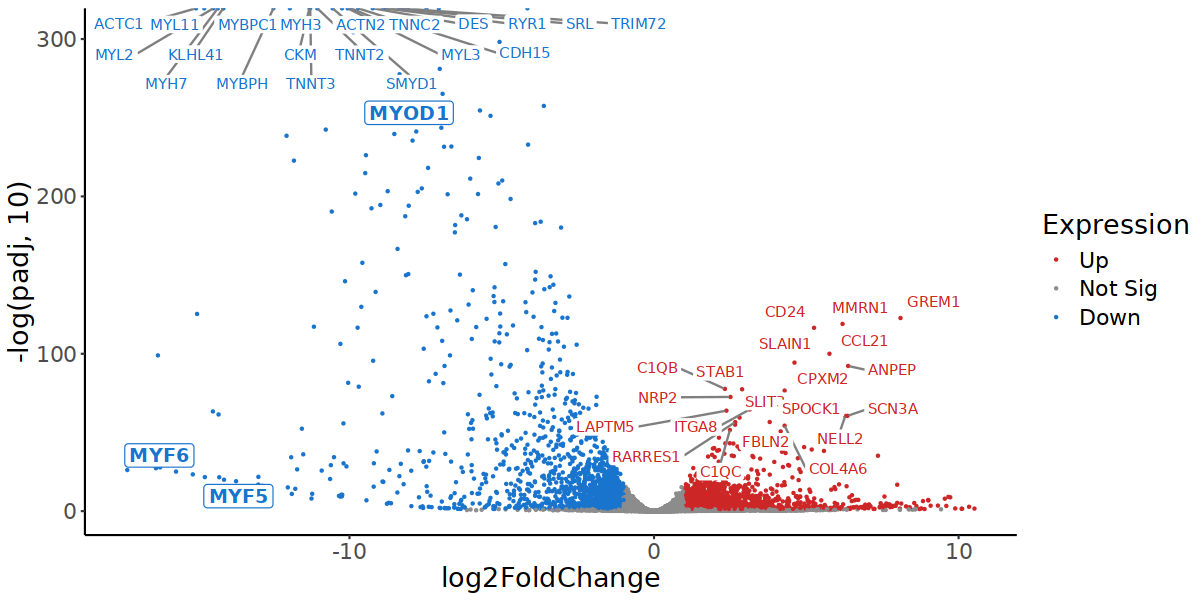

In [120]:
options(repr.plot.width=10, repr.plot.height = 5)
Volcano_plot(data[[4]], 20, mark = c("MYF5","MYF6","MYOD"))

In [121]:
png("Figure_SKM/VolcanoE62_axisblank.png",width=6,height=4,units="in",res=1200)
Volcano_plot_blackname(data[[4]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

In [122]:
png("Figure_SKM/VolcanoE62.png",width=7,height=4,units="in",res=1200)
Volcano_plot(data[[4]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

In [123]:
png("Figure_SKM/VolcanoE62_blank.png",width=6,height=4,units="in",res=1200)
Volcano_plot_noname(data[[4]], 20, mark = c("MYF5","MYF6","MYOD"))
dev.off() 

png 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


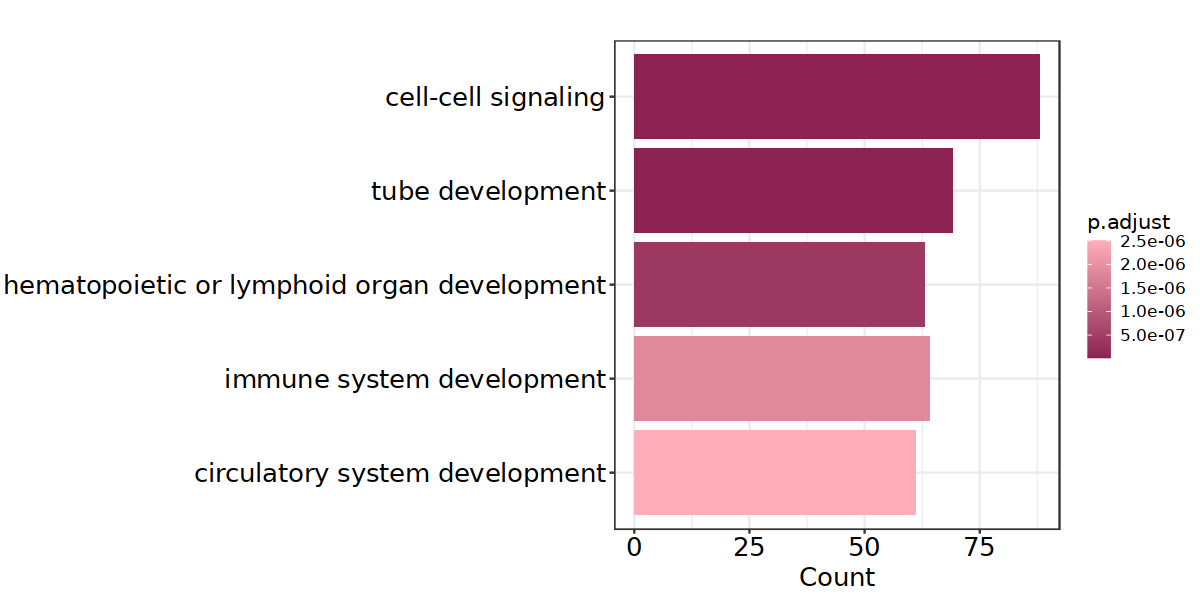

In [124]:
barplot(Up_pathway[[4]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 15, label_format = 60) +
        scale_fill_gradient(low = "violetred4", high = "lightpink1") +
        theme(legend.key.size = unit(5, 'mm'),
             legend.text=element_text(size=10),
             legend.title=element_text(size=12))

In [125]:
png("Figure_SKM/GOUp4.png",width=1.1,height=2.1,units="in",res=1200)
barplot(Up_pathway[[4]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 0, label_format = 60) +
        scale_fill_gradient(low = "violetred4", high = "lightpink1") +
        theme(legend.position = "none")
dev.off() 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


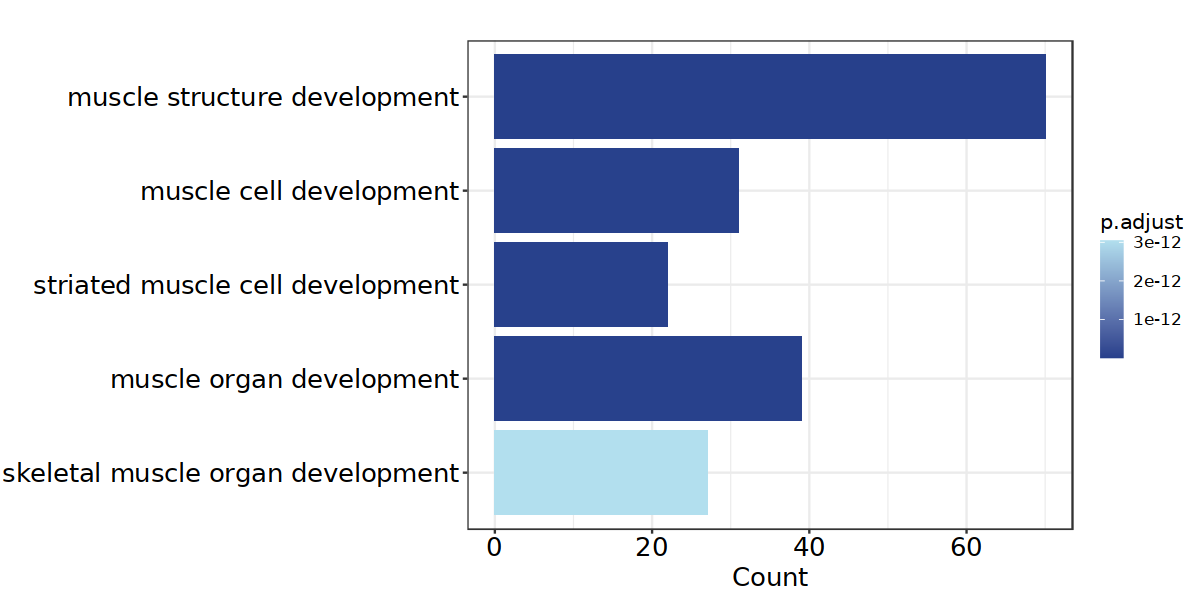

In [126]:
barplot(Down_pathway[[4]] %>%
  filter(str_detect(Description,"pathway|signaling|development")) %>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 15, label_format = 40) +
        scale_fill_gradient(low = "royalblue4", high = "lightblue2")+
        theme(legend.key.size = unit(5, 'mm'),
             legend.text=element_text(size=10),
             legend.title=element_text(size=12))

In [127]:
png("Figure_SKM/GODown4.png",width=1.1,height=2.1,units="in",res=1200)
barplot(Down_pathway[[4]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")),
        showCategory=5, font.size = 0, label_format = 60) +
        scale_fill_gradient(low = "royalblue4", high = "lightblue2") +
        theme(legend.position = "none")
dev.off() 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

In [128]:
MG <- c(str_subset(tx2gene$external_gene_name, "MYH") %>% unique(), "MYOG", "MYOD1","MYF5","MYF6","TNNI1","TNNI2","TNNI3","DES","ACTG1","MYLK","MYLK2","MYLK3","PAX3","PAX7","DMD","TWIST1","TWIST2","MYOT","ETV2","TEK","VEGFA","EMCN","CDH5")

In [129]:
MG <- Up_pathway[[4]] %>%
  filter(str_detect(Description,"pathway|signaling|development"))%>%
  filter(!str_detect(Description,"regulation")) %>%
  as.data.frame() %>%
  filter(Description %in% c("tube development", "hematopoietic or lymphoid organ development", "immune system development")) %>%
  pull(geneID) %>%
  strsplit(split = '/') %>%
  unlist() %>%
  unique() %>%
  c(MG)

In [130]:
scale <- scale(t(counts(dds_res_E62, normalized=T)[rownames(dds_res_E62) %in% MG,]))
res_scaled <- t(scale)

In [131]:
sd <- apply(res_scaled[,1:2],1, sd) + apply(res_scaled[,3:4],1, sd) 

In [132]:
MG <- names(sort(sd)[1:30])
MG <- MG[MG != "IFN-OMEGA-6"]
MG <- c(MG,"MYLK","MYF5")

In [133]:
length(MG)

[1] 31

In [134]:
scale <- scale(t(counts(dds_res_E62, normalized=T)[rownames(dds_res_E62) %in% MG,]))
res_scaled <- t(scale)

In [135]:
res_scaled <- res_scaled[, c("WT62_0987-3_RHL_S9_L001", "WT62_0987-4_RHL_S10_L001", "212-4281_E62SKM_RHL_Emb1_S1", "212-4281_E62SKM_RHL_Emb4_S2")]

In [136]:
col_fun <- colorRamp2(quantile(res_scaled, c(0.05, 0.5, 0.95)), c("blue", "black", "red"))

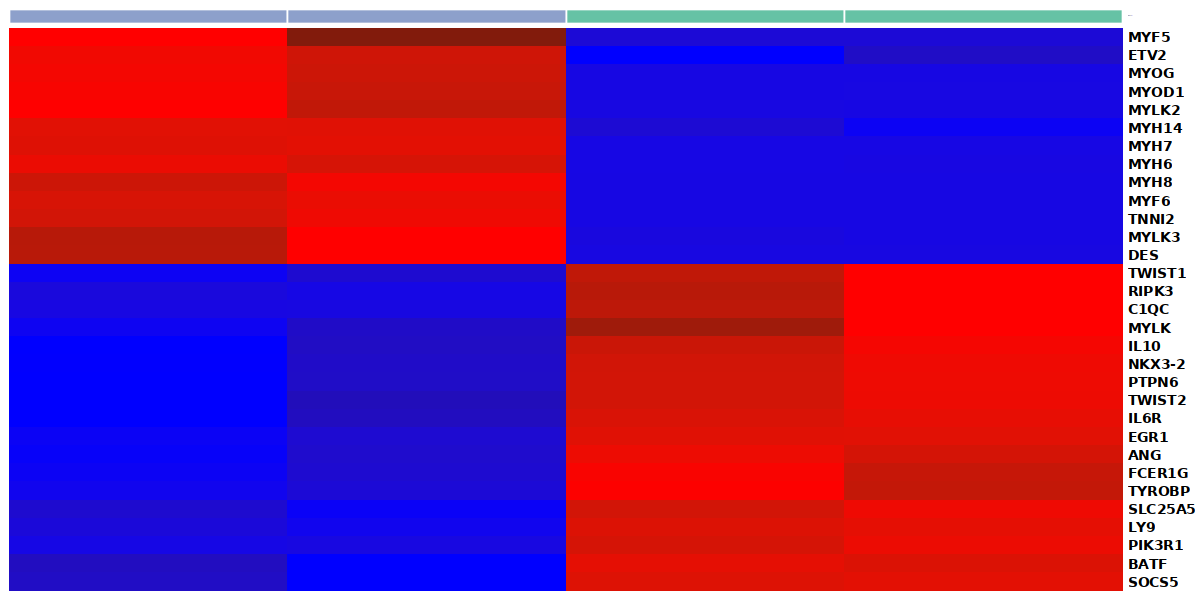

In [137]:
ht_opt$message = F
set.seed(5)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled,
cluster_rows = T, #Cluster the genes according to the pre-defined gene dendrogram
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
#row_km = 2,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

clusterlist <- row_order(draw(gene_heatmap))

In [138]:
png("Figure_SKM/MG_heatmap_E62_updated.png",width=2.5,height=5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

### E62 long updated

In [139]:
MG <- c("MYF5", "ETV2", "MYOG", "MYOD1", "MYLK2", "MYH14", "MYH7", "MYH6", "MYH8", "MYF6", "TNNI2", "MYLK3", "DES","LRP4","ETV4","MUSK", "TWIST1", "RIPK3", "C1QC", "MYLK", "IL10", "NKX3-2", "PTPN6", "TWIST2", "IL6R", "EGR1", "ANG", "FCER1G", "TYROBP", "SLC25A5", "LY9", "PIK3R1", "BATF", "SOCS5","AGRN","SOX10")

In [140]:
scale <- scale(t(counts(dds_res_E62, normalized=T)[rownames(dds_res_E62) %in% MG,]))
res_scaled <- t(scale)

In [141]:
res_scaled <- res_scaled[MG, c("WT62_0987-3_RHL_S9_L001", "WT62_0987-4_RHL_S10_L001", "212-4281_E62SKM_RHL_Emb1_S1", "212-4281_E62SKM_RHL_Emb4_S2")]

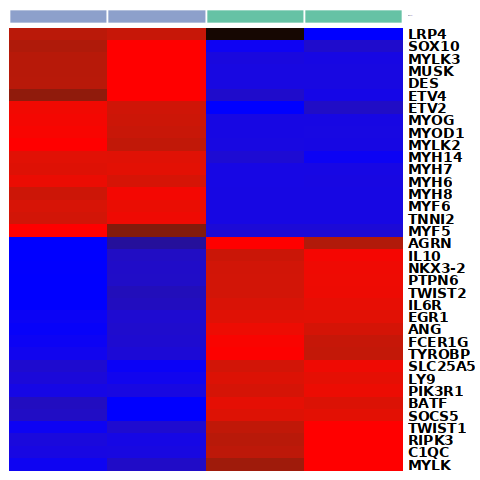

In [142]:
options(repr.plot.width=4, repr.plot.height = 4)
ht_opt$message = F
set.seed(5)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled,
cluster_rows = T, #Cluster the genes according to the pre-defined gene dendrogram
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [143]:
png("Figure_SKM/MG_heatmap_E62_updated.png",width=2.5,height=2,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

### E62

In [144]:
scale <- scale(t(counts(dds_res_E62, normalized=T)[rownames(dds_res_E62) %in% c("LRP4","ETV4","MUSK","SOX10","AGRN"),]))
res_scaled <- t(scale)

In [145]:
res_scaled <- res_scaled[c("LRP4","ETV4","MUSK","SOX10","AGRN"), c("WT62_0987-3_RHL_S9_L001", "WT62_0987-4_RHL_S10_L001", "212-4281_E62SKM_RHL_Emb1_S1", "212-4281_E62SKM_RHL_Emb4_S2")]

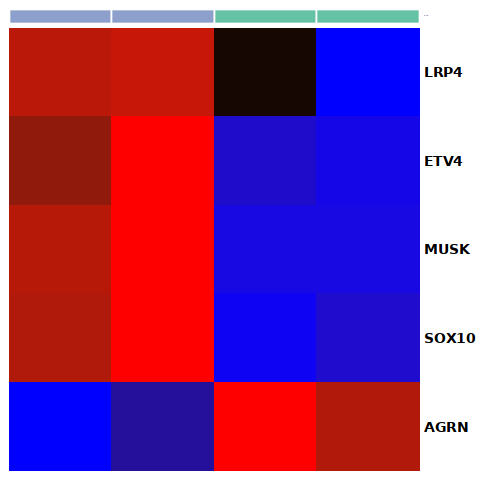

In [146]:
options(repr.plot.width=4, repr.plot.height = 4)
ht_opt$message = F
set.seed(5)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled,
cluster_rows = F, #Cluster the genes according to the pre-defined gene dendrogram
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [147]:
png("Figure_SKM/MG_heatmap_E62_v2.png",width=2.5,height=1.5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

### E90

In [148]:
scale <- scale(t(counts(dds_res_E90, normalized=T)[rownames(dds_res_E90) %in% MG,]))
res_scaled <- t(scale)

In [149]:
res_scaled <- res_scaled[c("LRP4","ETV4","MUSK","SOX10","AGRN"),c("6132-1_Right_Gastroc_S15", "6132-3_Right_Gastroc_S18", "6132-2_Left_Sol_S16", "6132-3_Left_Sol_S17")]

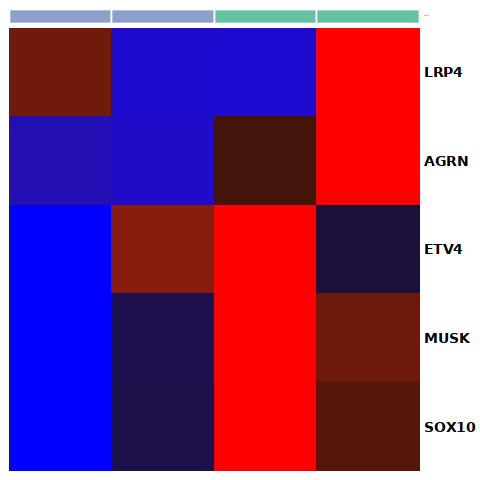

In [150]:
ht_opt$message = F
set.seed(5)

gene_heatmap <- ComplexHeatmap::Heatmap(
res_scaled,
cluster_rows = T, #Cluster the genes according to the pre-defined gene dendrogram
cluster_columns = F, #Cluster the sample according to the pre-defined sample dendrogram
row_title = NULL, #Name the cluster
row_title_rot = 0, #Rotate the row name
top_annotation = column_annotation,
show_heatmap_legend = FALSE,
show_row_names = T,
show_column_names = F,
show_column_dend = F,
col = col_fun,
column_dend_height = unit(0, "mm"),
show_row_dend = F, #Not to put row dendrogram on the left
row_names_gp = gpar(fontsize = 8, fontfamily = "sans", fontface = "bold"),
heatmap_legend_param = list(title="Counts",legend_direction = "vertical", title_gp = gpar(fontsize = 9), labels_gp = gpar(fontsize = 9))
) 
gene_heatmap

In [151]:
png("Figure_SKM/MG_heatmap_E90_v2.png",width=2.5,height=1.5,units="in",res=800)
draw(gene_heatmap)
dev.off() 

png 
  2

# Helight genes that are DE in comparsion: E62 vs E90

In [152]:
Muscle_MG <- c('MYF5','MYH1','MYH11','MYH4','MYH8','MYL10','MYL3','MYL4','MYL9','MYLK','TWIST1','TWIST2','VEGFA',
               # List proveided by Dan
              'ATP4A','RYR1','CACNA1S','DTNA','DMD','ACTA1','TNNC1','TNNC2','TPM1','TPM2','MYH3',"PAX7","MYOD1","MYF6",
              "LRP4","ETV4","MUSK","SOX10","P2RX3","SV2B","AGRN","GABRB3","PTGIR",'MYOG','LAMB1','LAMB2','LAMB3')

In [153]:
scale <- scale(t(counts(dds_res_WT, normalized=T)[Muscle_MG,]))
res_scaled <- t(scale)

In [154]:
sddata <- data.frame(gene = rownames(res_scaled),
           E41_sd = apply(res_scaled[,filter(coldata_WT, time == "E41")$sample],1,sd),
           E62_sd = apply(res_scaled[,filter(coldata_WT, time == "E62")$sample],1,sd),
           E90_sd = apply(res_scaled[,filter(coldata_WT, time == "E90")$sample],1,sd))

In [155]:
plotdata <- data.frame(gene = rownames(res_scaled),
           E41 = apply(res_scaled[,filter(coldata_WT, time == "E41")$sample],1,mean),
           E62 = apply(res_scaled[,filter(coldata_WT, time == "E62")$sample],1,mean),
           E90 = apply(res_scaled[,filter(coldata_WT, time == "E90")$sample],1,mean)) %>%
           cbind(sddata %>% select(-gene)) %>%
           mutate(Change1 = as.character(data[[1]][Muscle_MG,]$Expression),
                  Change2 = as.character(data[[2]][Muscle_MG,]$Expression))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


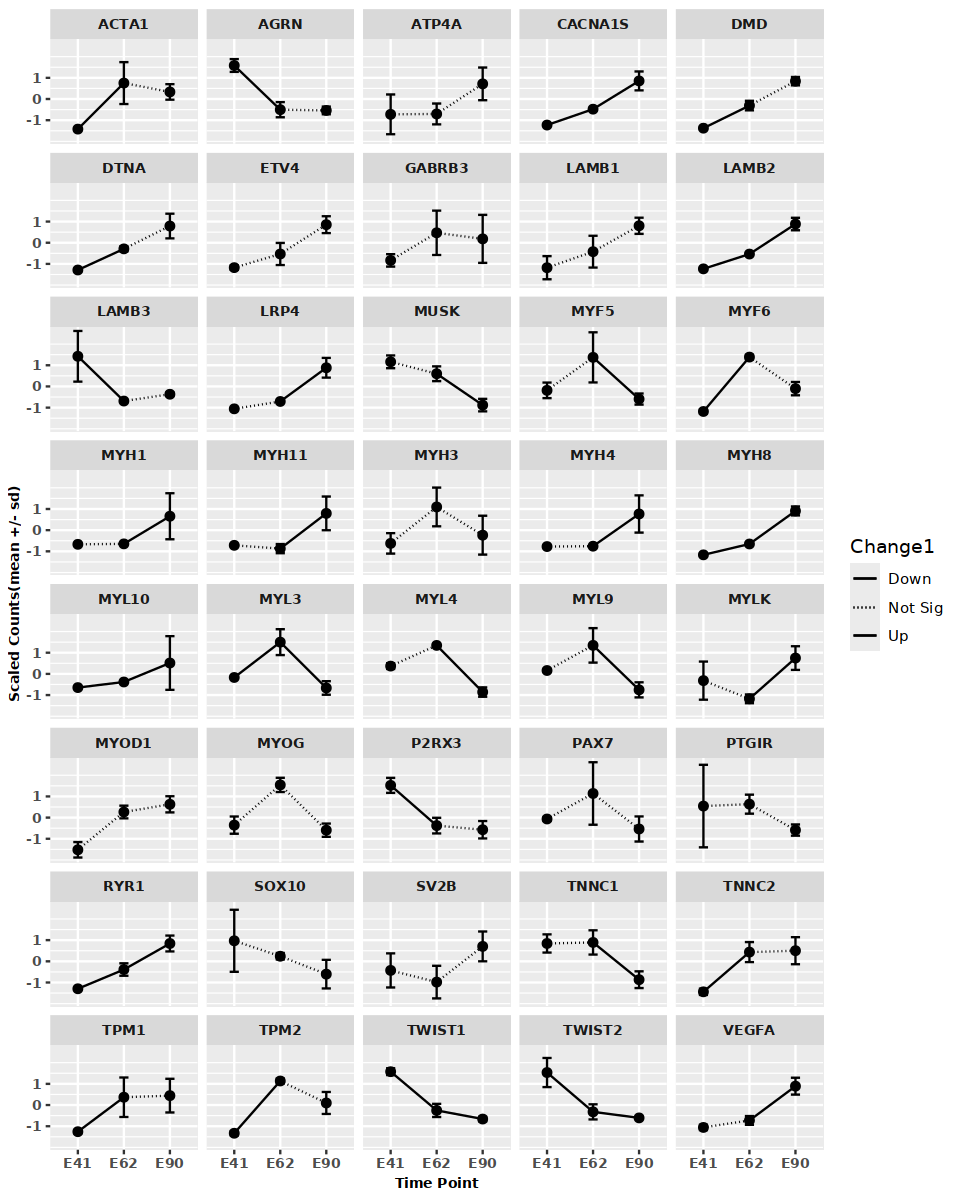

In [156]:
options(repr.plot.width=8, repr.plot.height = 10)
# Reshape the data to have a single time point variable
df <- plotdata %>%
  gather(key = "TimePoint", value = "Expression", -gene, -Change1, -Change2, -E41_sd, -E62_sd, -E90_sd)

# Create the plot
p <- ggplot(df, aes(x = TimePoint, y = Expression, group = gene)) +
  geom_line(data = subset(df, TimePoint == "E41" | TimePoint == "E62"),
            aes(linetype = Change1), size = 0.5) +
  geom_line(data = subset(df, TimePoint == "E62" | TimePoint == "E90"),
            aes(linetype = Change2), size = 0.5) +
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = Expression - E41_sd, ymax = Expression + E41_sd),
                data = subset(df, TimePoint == "E41"),
                width = 0.2) +
  geom_errorbar(aes(ymin = Expression - E62_sd, ymax = Expression + E62_sd),
                data = subset(df, TimePoint == "E62"),
                width = 0.2) +  
  geom_errorbar(aes(ymin = Expression - E90_sd, ymax = Expression + E90_sd),
                data = subset(df, TimePoint == "E90"),
                width = 0.2) +
facet_wrap(vars(gene), ncol = 5)+
scale_color_manual(values = mycol)+ 
theme(axis.text=element_text(size = 8, face = "bold", family="Ariel"), 
                                            axis.title=element_text(size = 8, face = "bold", family="Ariel"),
                                            strip.text = element_text(size = 8, face = "bold", family="Ariel"))+
 scale_y_continuous(breaks = c(-1, 0, 1)) +
  scale_linetype_manual(values = c("Up" = "solid", "Down" = "solid", "Not Sig" = "dotted")) +
 labs(x = "Time Point", y = "Scaled Counts(mean +/- sd)")
p

In [157]:
ggsave(p, width = 8, height = 10, units = "in", file = "Figure_SKM/WT_timeeffect.png")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


## Absolute levels for MYF5/MYOD/MYF6 as well as for DMD and Laminin

In [158]:
coldata_3E <- coldata %>% filter(time %in% c("E41", "E62", "E90")) %>%
mutate(condition_time = str_c(condition,time, sep = "_"))

In [159]:
coldata_3E

sample,condition,time,condition_time
<chr>,<chr>,<chr>,<chr>
212-4281_E62SKM_RHL_Emb1_S1,SKM_Null,E62,SKM_Null_E62
212-4281_E62SKM_RHL_Emb4_S2,SKM_Null,E62,SKM_Null_E62
6132-1_Right_Gastroc_S15,WT,E90,WT_E90
6132-2_Left_Sol_S16,WT,E90,WT_E90
6132-3_Left_Sol_S17,WT,E90,WT_E90
6132-3_Right_Gastroc_S18,WT,E90,WT_E90
SKM_0923-1_RHL_S5_L001,SKM_Null,E41,SKM_Null_E41
SKM_0923-3_RHL_S6_L001,SKM_Null,E41,SKM_Null_E41
WT62_0987-3_RHL_S9_L001,WT,E62,WT_E62


In [160]:
remain_sample <- coldata_3E %>% pull(sample)

In [161]:
txi_3E <- lapply(txi_full, function(x) if(is.matrix(x)) return(x[, remain_sample]) else return(x[remain_sample]))

In [162]:
txi_3E$countsFromAbundance <- txi_full$countsFromAbundance

In [163]:
all(txi_3E$sample == colnames(txi_3E$counts))

[1] TRUE

In [164]:
dds_3E <- DESeqDataSetFromTximport(txi_3E, coldata_3E,  design = ~ condition_time)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [165]:
summary(rowSums(counts(dds_3E)) >= 10)

   Mode   FALSE    TRUE 
logical     750   14933 

In [166]:
dds_res_3E <- DESeq(dds_3E)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [167]:
df <- counts(dds_res_3E)[c("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3'),] %>%
t() %>%
as.data.frame() %>%
cbind(coldata_3E) %>%
pivot_longer(cols = c("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3'), names_to = "gene", values_to = "counts") %>%
mutate(condition_time = factor(condition_time, levels = c('WT_E41','WT_E62','WT_E90','SKM_Null_E41','SKM_Null_E62'))) %>%
  group_by(gene, condition_time, condition, time) %>%
  summarize(sd_count = sd(counts), mean_count = mean(counts))

`summarise()` has grouped output by 'gene', 'condition_time', 'condition'. You
can override using the `.groups` argument.


In [168]:
p_hist <- lapply(list("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3'), function(i){
 ggplot(df %>% filter(gene == i), aes(x = condition_time, y = mean_count)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(aes(ymin = mean_count - sd_count, ymax = mean_count + sd_count),
                position = position_dodge(width = 0.9), width = 0.2) + 
 #theme_bw() +
    labs(title = i) +
    ylab("Row Counts") +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 8, family = "sans", face = "bold"),
    axis.text = element_text(size = 8, family = "sans", face = "bold"),
    axis.line = element_line(colour = "black"),
    strip.text = element_text(size = 8, family = "sans", face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 8, family = "sans", face = "bold"),
    panel.grid = element_blank(),
   panel.background = element_blank())   
    
})
names(p_hist) <- c("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3')

In [169]:
p_hist <- lapply(list("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3'), function(i){
 ggplot(df %>% filter(gene == i), aes(x = condition_time, y = mean_count)) +
  geom_bar(stat = "identity", position = "dodge", fill = "grey85", color = "black", aes(linetype = condition)) +
  geom_errorbar(aes(ymin = mean_count - sd_count, ymax = mean_count + sd_count),
                position = position_dodge(width = 0.9), width = 0.2) + 
    labs(title = i) +
    ylab("Row Counts") +
  scale_linetype_manual(values = c("WT" = "solid", "SKM_Null" = "dashed")) + 
     scale_x_discrete(labels = function(x) gsub(".*_", "", x)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 8, family = "sans", face = "bold"),
    axis.text = element_text(size = 8, family = "sans", face = "bold"),
    axis.line = element_line(colour = "black"),
    strip.text = element_text(size = 8, family = "sans", face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 8, family = "sans", face = "bold"),
    panel.grid = element_blank(),
    panel.background = element_blank(),
    legend.title = element_blank(),  # Legend title size and font
    legend.text = element_text(size = 8, family = "sans", face = "bold"))   
    
})
names(p_hist) <- c("MYF5","MYF6","MYOD1","DMD",'LAMB1','LAMB2','LAMB3')

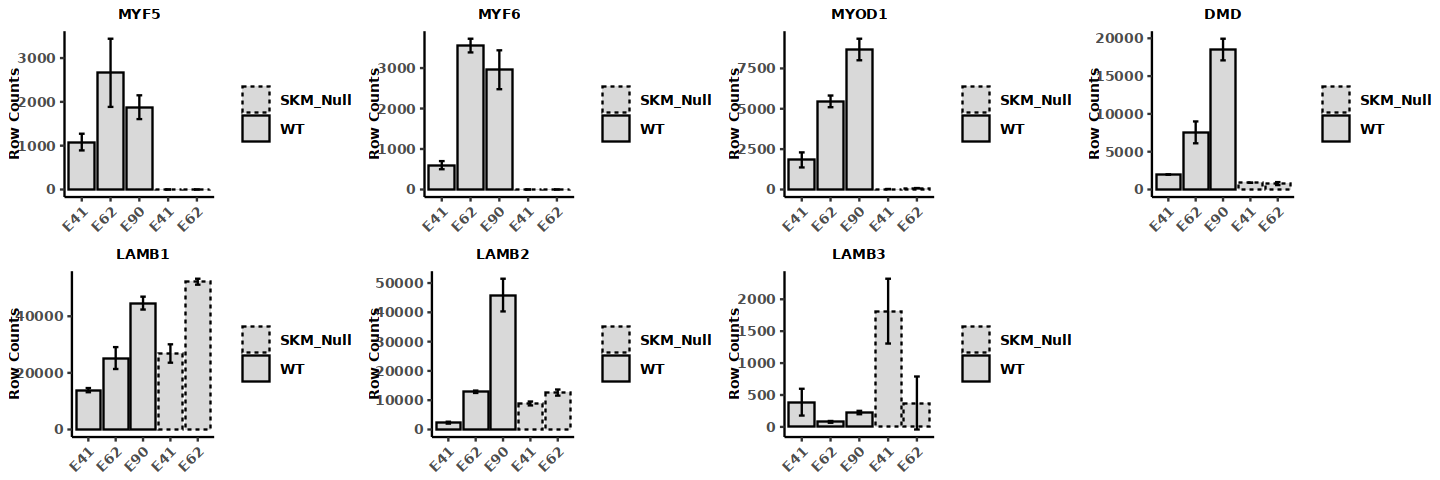

In [170]:
options(repr.plot.width=12, repr.plot.height = 4)
cowplot::plot_grid(plotlist = p_hist, ncol = 4)

In [171]:
for (i in 1:length(p_hist)){
ggsave(p_hist[[i]], width = 4, height = 2.5, units = "in", file = sprintf("Figure_SKM/%s.png", names(p_hist)[i]))
}

In [172]:
ggsave(cowplot::plot_grid(plotlist = p_hist, ncol = 4), width = 12, height = 4, units = "in", file = "Figure_SKM/gene_hist.png")

In [173]:
sprintf("zip -r Figure_SKM.zip Figure_SKM") %>% system()

# System information

In [174]:
Sys.time() - start_time

Time difference of 2.372574 mins

In [175]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.9 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/ma000332/miniconda3/envs/sc/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] jsonlite_1.8.8              ggrepel_0.9.2              
 [3] ReactomePA_1.42.0           scales_1.3.0               
 [5] factoextra_1.0.7            vsn_3.66.0                 
 [7] pheatmap_1.0.12             RColorBrewer_1.1-3         
 [9] clusterProfiler_4.7.0       org.Ss.eg.db_3.16.0       